In [1]:
import pandas as pd
import numpy as np
import os, time, stat, io, glob, pickle

import matplotlib.pyplot as plt
import matplotlib as mpl
plt.style.use('fivethirtyeight')
import plotly.io as pio

from pandas.plotting import table

%load_ext autoreload
%autoreload 2

https://raw.githubusercontent.com/fivethirtyeight/data/master/election-forecasts-2020/README.md
https://raw.githubusercontent.com/fivethirtyeight/data/master/polls/README.md

In [2]:
df_census_raw = pd.read_csv(
    'https://www2.census.gov/programs-surveys/popest/datasets/2010-2019/counties/totals/co-est2019-alldata.csv', 
    encoding = "ISO-8859-1")
df_census_raw.head()


,SUMLEV,REGION,DIVISION,STATE,COUNTY,STNAME,CTYNAME,CENSUS2010POP,ESTIMATESBASE2010,POPESTIMATE2010,...,RDOMESTICMIG2019,RNETMIG2011,RNETMIG2012,RNETMIG2013,RNETMIG2014,RNETMIG2015,RNETMIG2016,RNETMIG2017,RNETMIG2018,RNETMIG2019
0,40,3,6,1,0,Alabama,Alabama,4779736,4780125,4785437,...,1.917501,0.578434,1.186314,1.522549,0.563489,0.626357,0.745172,1.090366,1.773786,2.483744
1,50,3,6,1,1,Alabama,Autauga County,54571,54597,54773,...,4.847310,6.018182,-6.226119,-3.902226,1.970443,-1.712875,4.777171,0.849656,0.540916,4.560062
2,50,3,6,1,3,Alabama,Baldwin County,182265,182265,183112,...,24.017829,16.641870,17.488579,22.751474,20.184334,17.725964,21.279291,22.398256,24.727215,24.380567
3,50,3,6,1,5,Alabama,Barbour County,27457,27455,27327,...,-5.690302,0.292676,-6.897817,-8.132185,-5.140431,-15.724575,-18.238016,-24.998528,-8.754922,-5.165664
4,50,3,6,1,7,Alabama,Bibb County,22915,22915,22870,...,1.385134,-4.998356,-3.787545,-5.797999,1.331144,1.329817,-0.708717,-3.234669,-6.857092,1.831952


In [3]:
df_model_states_raw = pd.read_csv('https://projects.fivethirtyeight.com/2020-general-data/presidential_state_toplines_2020.csv')
df_model_states_raw.head()


,cycle,branch,model,modeldate,candidate_inc,candidate_chal,candidate_3rd,state,tipping,vpi,...,margin_lo,win_EC_if_win_state_inc,win_EC_if_win_state_chal,win_state_if_win_EC_inc,win_state_if_win_EC_chal,state_turnout,state_turnout_hi,state_turnout_lo,timestamp,simulations
0,2020,President,polls-plus,10/28/2020,Trump,Biden,NaN,Wyoming,0.000013,0.007394,...,27.50507,0.115491,0.979592,0.999783,0.001363,272928.7,317754.0,229676.0,10:29:04 28 Oct 2020,40000
1,2020,President,polls-plus,10/28/2020,Trump,Biden,NaN,Wisconsin,0.060700,2.842797,...,-15.08174,0.829407,0.927567,0.442470,0.989064,3310824.0,3737713.0,2895063.0,10:29:04 28 Oct 2020,40000
2,2020,President,polls-plus,10/28/2020,Trump,Biden,NaN,West Virginia,0.000050,0.011461,...,15.22908,0.116527,0.982759,0.998267,0.012953,749385.3,866117.5,636684.0,10:29:04 28 Oct 2020,40000
3,2020,President,polls-plus,10/28/2020,Trump,Biden,NaN,Washington,0.002887,0.115889,...,-33.62102,0.330808,0.882234,0.028386,0.992501,3865393.0,4383465.0,3361572.0,10:29:04 28 Oct 2020,40000
4,2020,President,polls-plus,10/28/2020,Trump,Biden,NaN,Virginia,0.011588,0.393794,...,-18.80868,0.849873,0.887368,0.072373,0.998352,4585481.0,5177173.0,4003434.0,10:29:04 28 Oct 2020,40000


In [4]:
df_polls_states_raw = pd.read_csv('https://projects.fivethirtyeight.com/polls-page/president_polls.csv')
df_polls_states_raw.head()


,question_id,poll_id,cycle,state,pollster_id,pollster,sponsor_ids,sponsors,display_name,pollster_rating_id,...,created_at,notes,url,stage,race_id,answer,candidate_id,candidate_name,candidate_party,pct
0,135090,72057,2020,North Carolina,383,Public Policy Polling,946,Protect Our Care,Public Policy Polling,263.0,...,10/27/20 15:35,NaN,https://www.protectourcare.org/wp-content/uplo...,general,6238,Biden,13256,Joseph R. Biden Jr.,DEM,51.0
1,135090,72057,2020,North Carolina,383,Public Policy Polling,946,Protect Our Care,Public Policy Polling,263.0,...,10/27/20 15:35,NaN,https://www.protectourcare.org/wp-content/uplo...,general,6238,Trump,13254,Donald Trump,REP,47.0
2,135098,72062,2020,Montana,383,Public Policy Polling,946,Protect Our Care,Public Policy Polling,263.0,...,10/27/20 16:31,NaN,https://www.protectourcare.org/wp-content/uplo...,general,6237,Biden,13256,Joseph R. Biden Jr.,DEM,47.0
3,135098,72062,2020,Montana,383,Public Policy Polling,946,Protect Our Care,Public Policy Polling,263.0,...,10/27/20 16:31,NaN,https://www.protectourcare.org/wp-content/uplo...,general,6237,Trump,13254,Donald Trump,REP,49.0
4,135152,72083,2020,NaN,568,YouGov,352,Economist,YouGov,391.0,...,10/28/20 09:13,NaN,https://docs.cdn.yougov.com/nzc8dt85gn/econTab...,general,6210,Biden,13256,Joseph R. Biden Jr.,DEM,51.0


In [5]:
df_model_national_raw = pd.read_csv('https://projects.fivethirtyeight.com/2020-general-data/presidential_national_toplines_2020.csv')
print(df_model_national_raw.columns)
df_model_national_raw.head()


Index(['cycle', 'branch', 'model', 'modeldate', 'candidate_inc',
       'candidate_chal', 'candidate_3rd', 'ecwin_inc', 'ecwin_chal',
       'ecwin_3rd', 'ec_nomajority', 'popwin_inc', 'popwin_chal', 'popwin_3rd',
       'ev_inc', 'ev_chal', 'ev_3rd', 'ev_inc_hi', 'ev_chal_hi', 'ev_3rd_hi',
       'ev_inc_lo', 'ev_chal_lo', 'ev_3rd_lo', 'national_voteshare_inc',
       'national_voteshare_chal', 'national_voteshare_3rd',
       'nat_voteshare_other', 'national_voteshare_inc_hi',
       'national_voteshare_chal_hi', 'national_voteshare_3rd_hi',
       'nat_voteshare_other_hi', 'national_voteshare_inc_lo',
       'national_voteshare_chal_lo', 'national_voteshare_3rd_lo',
       'nat_voteshare_other_lo', 'national_turnout', 'national_turnout_hi',
       'national_turnout_lo', 'timestamp', 'simulations'],
      dtype='object')


,cycle,branch,model,modeldate,candidate_inc,candidate_chal,candidate_3rd,ecwin_inc,ecwin_chal,ecwin_3rd,...,nat_voteshare_other_hi,national_voteshare_inc_lo,national_voteshare_chal_lo,national_voteshare_3rd_lo,nat_voteshare_other_lo,national_turnout,national_turnout_hi,national_turnout_lo,timestamp,simulations
0,2020,President,polls-plus,10/28/2020,Trump,Biden,NaN,0.115375,0.880100,NaN,...,1.868595,42.90291,50.55973,NaN,0.698105,154000000.0,164000000.0,143000000.0,10:29:04 28 Oct 2020,40000
1,2020,President,polls-plus,10/27/2020,Trump,Biden,NaN,0.118900,0.875525,NaN,...,1.874326,42.74829,50.61196,NaN,0.696913,154000000.0,164000000.0,143000000.0,21:01:03 27 Oct 2020,40000
2,2020,President,polls-plus,10/26/2020,Trump,Biden,NaN,0.123550,0.870825,NaN,...,1.880471,42.69503,50.58232,NaN,0.696958,154000000.0,164000000.0,143000000.0,20:38:03 26 Oct 2020,40000
3,2020,President,polls-plus,10/25/2020,Trump,Biden,NaN,0.123075,0.871125,NaN,...,1.884866,42.63616,50.54306,NaN,0.695292,154000000.0,164000000.0,143000000.0,20:47:03 25 Oct 2020,40000
4,2020,President,polls-plus,10/24/2020,Trump,Biden,NaN,0.129600,0.864925,NaN,...,1.891269,42.60899,50.48753,NaN,0.696342,154000000.0,164000000.0,143000000.0,22:24:03 24 Oct 2020,40000


# Data Clean Up

In [6]:
df_model_states = df_model_states_raw.copy()
df_model_states['modeldate'] = pd.to_datetime(df_model_states['modeldate'])
df_model_states['timestamp'] = pd.to_datetime(df_model_states['timestamp'])
df_model_states = df_model_states.set_index(['modeldate','state'])
print(df_model_states.columns)
df_model_states.head()


Index(['cycle', 'branch', 'model', 'candidate_inc', 'candidate_chal',
       'candidate_3rd', 'tipping', 'vpi', 'winstate_inc', 'winstate_chal',
       'winstate_3rd', 'voteshare_inc', 'voteshare_chal', 'voteshare_3rd',
       'voteshare_other', 'voteshare_inc_hi', 'voteshare_chal_hi',
       'voteshare_3rd_hi', 'voteshare_other_hi', 'voteshare_inc_lo',
       'voteshare_chal_lo', 'voteshare_3rd_lo', 'voteshare_other_lo', 'margin',
       'margin_hi', 'margin_lo', 'win_EC_if_win_state_inc',
       'win_EC_if_win_state_chal', 'win_state_if_win_EC_inc',
       'win_state_if_win_EC_chal', 'state_turnout', 'state_turnout_hi',
       'state_turnout_lo', 'timestamp', 'simulations'],
      dtype='object')


cycle     branch       model candidate_inc  \
modeldate  state                                                       
2020-10-28 Wyoming         2020  President  polls-plus         Trump   
           Wisconsin       2020  President  polls-plus         Trump   
           West Virginia   2020  President  polls-plus         Trump   
           Washington      2020  President  polls-plus         Trump   
           Virginia        2020  President  polls-plus         Trump   

                         candidate_chal  candidate_3rd   tipping       vpi  \
modeldate  state                                                             
2020-10-28 Wyoming                Biden            NaN  0.000013  0.007394   
           Wisconsin              Biden            NaN  0.060700  2.842797   
           West Virginia          Biden            NaN  0.000050  0.011461   
           Washington             Biden            NaN  0.002887  0.115889   
           Virginia               Biden            NaN  0.011588  0.393794   

                          winstate_inc  winstate_chal  ...  margin_lo  \
modeldate  state                                       ...              
2020-10-28 Wyoming            0.998775       0.001225  ...   27.50507   
           Wisconsin          0.061550       0.938450  ...  -15.08174   
           West Virginia      0.988400       0.011600  ...   15.22908   
           Washington         0.009900       0.990100  ...  -33.62102   
           Virginia           0.009825       0.990175  ...  -18.80868   

                          win_EC_if_win_state_inc  win_EC_if_win_state_chal  \
modeldate  state                                                              
2020-10-28 Wyoming                       0.115491                  0.979592   
           Wisconsin                     0.829407                  0.927567   
           West Virginia                 0.116527                  0.982759   
           Washington                    0.330808                  0.882234   
           Virginia                      0.849873                  0.887368   

                          win_state_if_win_EC_inc  win_state_if_win_EC_chal  \
modeldate  state                                                              
2020-10-28 Wyoming                       0.999783                  0.001363   
           Wisconsin                     0.442470                  0.989064   
           West Virginia                 0.998267                  0.012953   
           Washington                    0.028386                  0.992501   
           Virginia                      0.072373                  0.998352   

                          state_turnout  state_turnout_hi  state_turnout_lo  \
modeldate  state                                                              
2020-10-28 Wyoming             272928.7          317754.0          229676.0   
           Wisconsin          3310824.0         3737713.0         2895063.0   
           West Virginia       749385.3          866117.5          636684.0   
           Washington         3865393.0         4383465.0         3361572.0   
           Virginia           4585481.0         5177173.0         4003434.0   

                                   timestamp  simulations  
modeldate  state                                           
2020-10-28 Wyoming       2020-10-28 10:29:04        40000  
           Wisconsin     2020-10-28 10:29:04        40000  
           West Virginia 2020-10-28 10:29:04        40000  
           Washington    2020-10-28 10:29:04        40000  
           Virginia      2020-10-28 10:29:04        40000  

[5 rows x 35 columns]

In [7]:
df_model_national = df_model_national_raw.copy()
df_model_national['modeldate'] = pd.to_datetime(df_model_national['modeldate'])
df_model_national['timestamp'] = pd.to_datetime(df_model_national['timestamp'])
df_model_national = df_model_national.set_index(['modeldate'])
print(df_model_national.columns)
df_model_national.head()


Index(['cycle', 'branch', 'model', 'candidate_inc', 'candidate_chal',
       'candidate_3rd', 'ecwin_inc', 'ecwin_chal', 'ecwin_3rd',
       'ec_nomajority', 'popwin_inc', 'popwin_chal', 'popwin_3rd', 'ev_inc',
       'ev_chal', 'ev_3rd', 'ev_inc_hi', 'ev_chal_hi', 'ev_3rd_hi',
       'ev_inc_lo', 'ev_chal_lo', 'ev_3rd_lo', 'national_voteshare_inc',
       'national_voteshare_chal', 'national_voteshare_3rd',
       'nat_voteshare_other', 'national_voteshare_inc_hi',
       'national_voteshare_chal_hi', 'national_voteshare_3rd_hi',
       'nat_voteshare_other_hi', 'national_voteshare_inc_lo',
       'national_voteshare_chal_lo', 'national_voteshare_3rd_lo',
       'nat_voteshare_other_lo', 'national_turnout', 'national_turnout_hi',
       'national_turnout_lo', 'timestamp', 'simulations'],
      dtype='object')


,cycle,branch,model,candidate_inc,candidate_chal,candidate_3rd,ecwin_inc,ecwin_chal,ecwin_3rd,ec_nomajority,...,nat_voteshare_other_hi,national_voteshare_inc_lo,national_voteshare_chal_lo,national_voteshare_3rd_lo,nat_voteshare_other_lo,national_turnout,national_turnout_hi,national_turnout_lo,timestamp,simulations
modeldate,,,,,,,,,,,,,,,,,,,,,
2020-10-28,2020,President,polls-plus,Trump,Biden,NaN,0.115375,0.880100,NaN,0.004525,...,1.868595,42.90291,50.55973,NaN,0.698105,154000000.0,164000000.0,143000000.0,2020-10-28 10:29:04,40000
2020-10-27,2020,President,polls-plus,Trump,Biden,NaN,0.118900,0.875525,NaN,0.005575,...,1.874326,42.74829,50.61196,NaN,0.696913,154000000.0,164000000.0,143000000.0,2020-10-27 21:01:03,40000
2020-10-26,2020,President,polls-plus,Trump,Biden,NaN,0.123550,0.870825,NaN,0.005625,...,1.880471,42.69503,50.58232,NaN,0.696958,154000000.0,164000000.0,143000000.0,2020-10-26 20:38:03,40000
2020-10-25,2020,President,polls-plus,Trump,Biden,NaN,0.123075,0.871125,NaN,0.005800,...,1.884866,42.63616,50.54306,NaN,0.695292,154000000.0,164000000.0,143000000.0,2020-10-25 20:47:03,40000
2020-10-24,2020,President,polls-plus,Trump,Biden,NaN,0.129600,0.864925,NaN,0.005475,...,1.891269,42.60899,50.48753,NaN,0.696342,154000000.0,164000000.0,143000000.0,2020-10-24 22:24:03,40000


In [8]:
df_polls_states = df_polls_states_raw.copy()
df_polls_states['created_at'] = pd.to_datetime(df_polls_states['created_at'])
df_polls_states = df_polls_states.set_index(['created_at','state'])
print(df_polls_states.columns)
df_polls_states.head()


Index(['question_id', 'poll_id', 'cycle', 'pollster_id', 'pollster',
       'sponsor_ids', 'sponsors', 'display_name', 'pollster_rating_id',
       'pollster_rating_name', 'fte_grade', 'sample_size', 'population',
       'population_full', 'methodology', 'office_type', 'seat_number',
       'seat_name', 'start_date', 'end_date', 'election_date',
       'sponsor_candidate', 'internal', 'partisan', 'tracking',
       'nationwide_batch', 'ranked_choice_reallocated', 'notes', 'url',
       'stage', 'race_id', 'answer', 'candidate_id', 'candidate_name',
       'candidate_party', 'pct'],
      dtype='object')


question_id  poll_id  cycle  pollster_id  \
created_at          state                                                      
2020-10-27 15:35:00 North Carolina       135090    72057   2020          383   
                    North Carolina       135090    72057   2020          383   
2020-10-27 16:31:00 Montana              135098    72062   2020          383   
                    Montana              135098    72062   2020          383   
2020-10-28 09:13:00 NaN                  135152    72083   2020          568   

                                                 pollster sponsor_ids  \
created_at          state                                               
2020-10-27 15:35:00 North Carolina  Public Policy Polling         946   
                    North Carolina  Public Policy Polling         946   
2020-10-27 16:31:00 Montana         Public Policy Polling         946   
                    Montana         Public Policy Polling         946   
2020-10-28 09:13:00 NaN                            YouGov         352   

                                            sponsors           display_name  \
created_at          state                                                     
2020-10-27 15:35:00 North Carolina  Protect Our Care  Public Policy Polling   
                    North Carolina  Protect Our Care  Public Policy Polling   
2020-10-27 16:31:00 Montana         Protect Our Care  Public Policy Polling   
                    Montana         Protect Our Care  Public Policy Polling   
2020-10-28 09:13:00 NaN                    Economist                 YouGov   

                                    pollster_rating_id   pollster_rating_name  \
created_at          state                                                       
2020-10-27 15:35:00 North Carolina               263.0  Public Policy Polling   
                    North Carolina               263.0  Public Policy Polling   
2020-10-27 16:31:00 Montana                      263.0  Public Policy Polling   
                    Montana                      263.0  Public Policy Polling   
2020-10-28 09:13:00 NaN                          391.0                 YouGov   

                                    ... ranked_choice_reallocated  notes  \
created_at          state           ...                                    
2020-10-27 15:35:00 North Carolina  ...                     False    NaN   
                    North Carolina  ...                     False    NaN   
2020-10-27 16:31:00 Montana         ...                     False    NaN   
                    Montana         ...                     False    NaN   
2020-10-28 09:13:00 NaN             ...                     False    NaN   

                                                                                  url  \
created_at          state                                                               
2020-10-27 15:35:00 North Carolina  https://www.protectourcare.org/wp-content/uplo...   
                    North Carolina  https://www.protectourcare.org/wp-content/uplo...   
2020-10-27 16:31:00 Montana         https://www.protectourcare.org/wp-content/uplo...   
                    Montana         https://www.protectourcare.org/wp-content/uplo...   
2020-10-28 09:13:00 NaN             https://docs.cdn.yougov.com/nzc8dt85gn/econTab...   

                                      stage race_id answer  candidate_id  \
created_at          state                                                  
2020-10-27 15:35:00 North Carolina  general    6238  Biden         13256   
                    North Carolina  general    6238  Trump         13254   
2020-10-27 16:31:00 Montana         general    6237  Biden         13256   
                    Montana         general    6237  Trump         13254   
2020-10-28 09:13:00 NaN             general    6210  Biden         13256   

                                         candidate_name candidate_party   pct  
created_at          state                                              

# Charts

Text(0, -80, 'Model Analysis by @donnellymjd')

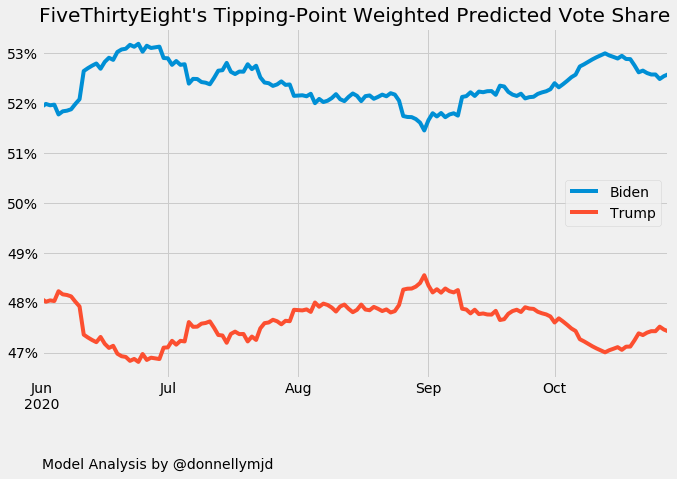

In [9]:
tippingpt_margin = df_model_states['margin'].mul(df_model_states['tipping']).unstack('modeldate').sum()

trump_weighted = tippingpt_margin.div(100).add(1).div(2)
biden_weighted = 1 - trump_weighted
ax = biden_weighted.plot(label='Biden', legend=True,
                         figsize=[10,6], 
                         title='FiveThirtyEight\'s Tipping-Point Weighted Predicted Vote Share'
                        )
trump_weighted.plot(ax=ax, label='Trump', legend=True)
ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0%}'))
# ax.set_ylim([0,1])
ax.set_xlabel('')
plt.annotate('Model Analysis by @donnellymjd',
                 (0, 0), (0, -80), xycoords='axes fraction', textcoords='offset points', va='top')


x - y = z
x + y = 1
y = 1-x

x - (1 - x) = z
2x - 1 = z
x = (z + 1) / 2


In [10]:
ymin, ymax = .3, .7

two_party_natl = df_model_national['national_voteshare_inc'].add(
    df_model_national['national_voteshare_chal'])

tippingpt_margin_bystate = df_model_states['margin'].mul(df_model_states['tipping']).unstack('modeldate')
top5contribs = tippingpt_margin_bystate.iloc[:,-1].abs().sort_values(ascending=False).iloc[:5].index.to_list()
tippingpt_margin = tippingpt_margin_bystate.sum()

df_chart = pd.DataFrame()

df_chart['trump_weighted'] = tippingpt_margin.div(100).add(1).div(2)
df_chart['biden_weighted'] = 1 - df_chart['trump_weighted']
# ax = df_chart['biden_weighted'].plot(label='Biden (Tipping Point States)', legend=True,
#                          figsize=[10,6], 
#                          title='FiveThirtyEight\'s \n Predicted Swing State Vote Share'
#                         )
# df_chart['trump_weighted'].plot(ax=ax, label='Trump (Tipping Point States)', legend=True)

last_dt = df_chart.last_valid_index()
df_chart_summary = pd.DataFrame(
    {'Biden':[
         df_chart.loc[last_dt,'biden_weighted'],
         df_chart.loc[last_dt,'biden_weighted']
                         - df_chart.loc[last_dt-pd.Timedelta(days=1),'biden_weighted'],
         df_chart.loc[last_dt,'biden_weighted']
                         - df_chart.loc[last_dt-pd.Timedelta(days=7),'biden_weighted'],
         df_chart.loc[last_dt,'biden_weighted']
                         - df_chart.loc[last_dt-pd.Timedelta(days=30),'biden_weighted'],
         df_model_national['national_voteshare_chal'].div(two_party_natl).loc[last_dt]
             ], 
     'Trump':[
         df_chart.loc[last_dt,'trump_weighted'],
         df_chart.loc[last_dt,'trump_weighted']
                         - df_chart.loc[last_dt-pd.Timedelta(days=1),'trump_weighted'],
         df_chart.loc[last_dt,'trump_weighted']
                         - df_chart.loc[last_dt-pd.Timedelta(days=7),'trump_weighted'],
         df_chart.loc[last_dt,'trump_weighted']
                         - df_chart.loc[last_dt-pd.Timedelta(days=30),'trump_weighted'],
         df_model_national['national_voteshare_inc'].div(two_party_natl).loc[last_dt]
             ]},
    index=["Swing State Vote Proj. (as of {:%b %d})".format(last_dt),'Change: 1-Day', 'Change: 7-Day', 'Change: 30-Day', 'Nat\'l Popular Vote Proj.']
)

df_chart_summary['Diff.'] = df_chart_summary['Biden'] - df_chart_summary['Trump']

df_chart_summary.applymap(lambda x: '{:.1%}'.format(x))


,Biden,Trump,Diff.
Swing State Vote Proj. (as of Oct 28),52.6%,47.4%,5.2%
Change: 1-Day,0.0%,-0.0%,0.1%
Change: 7-Day,-0.0%,0.0%,-0.1%
Change: 30-Day,0.4%,-0.4%,0.7%
Nat'l Popular Vote Proj.,53.9%,46.1%,7.8%


In [11]:
df_model_national['national_voteshare_chal'].div(two_party_natl).loc[last_dt]

0.5389116965562887

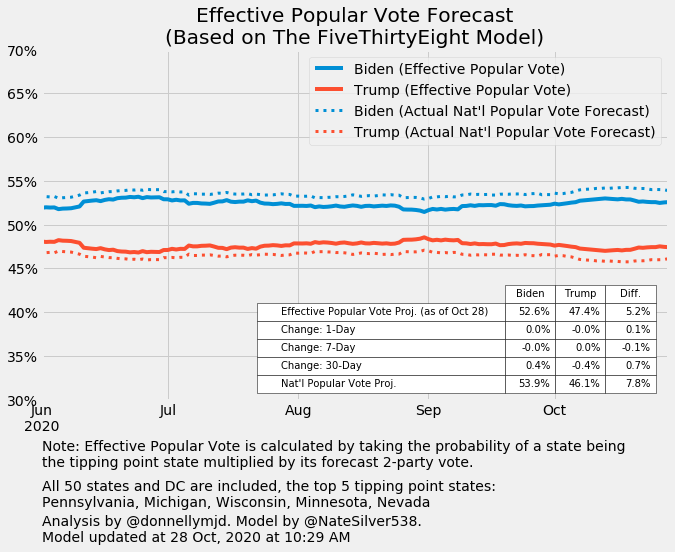

In [12]:
ymin, ymax = .3, .7

two_party_natl = df_model_national['national_voteshare_inc'].add(
    df_model_national['national_voteshare_chal'])

tippingpt_margin_bystate = df_model_states['margin'].mul(df_model_states['tipping']).unstack('modeldate')
top5contribs = tippingpt_margin_bystate.iloc[:,-1].abs().sort_values(ascending=False).iloc[:5].index.to_list()
tippingpt_margin = tippingpt_margin_bystate.sum()

df_chart = pd.DataFrame()

df_chart['trump_weighted'] = tippingpt_margin.div(100).add(1).div(2)
df_chart['biden_weighted'] = 1 - df_chart['trump_weighted']
ax = df_chart['biden_weighted'].plot(label='Biden (Effective Popular Vote)', legend=True,
                         figsize=[10,6], 
                         title='Effective Popular Vote Forecast\n(Based on The FiveThirtyEight Model)'
                        )
df_chart['trump_weighted'].plot(ax=ax, label='Trump (Effective Popular Vote)', legend=True)

last_dt = df_chart.last_valid_index()
df_chart_summary = pd.DataFrame(
    {'Biden':[
         df_chart.loc[last_dt,'biden_weighted'],
         df_chart.loc[last_dt,'biden_weighted']
                         - df_chart.loc[last_dt-pd.Timedelta(days=1),'biden_weighted'],
         df_chart.loc[last_dt,'biden_weighted']
                         - df_chart.loc[last_dt-pd.Timedelta(days=7),'biden_weighted'],
         df_chart.loc[last_dt,'biden_weighted']
                         - df_chart.loc[last_dt-pd.Timedelta(days=30),'biden_weighted'],
         df_model_national['national_voteshare_chal'].div(two_party_natl).loc[last_dt]
             ], 
     'Trump':[
         df_chart.loc[last_dt,'trump_weighted'],
         df_chart.loc[last_dt,'trump_weighted']
                         - df_chart.loc[last_dt-pd.Timedelta(days=1),'trump_weighted'],
         df_chart.loc[last_dt,'trump_weighted']
                         - df_chart.loc[last_dt-pd.Timedelta(days=7),'trump_weighted'],
         df_chart.loc[last_dt,'trump_weighted']
                         - df_chart.loc[last_dt-pd.Timedelta(days=30),'trump_weighted'],
         df_model_national['national_voteshare_inc'].div(two_party_natl).loc[last_dt]
             ]},
    index=["Effective Popular Vote Proj. (as of {:%b %d})".format(last_dt),'Change: 1-Day', 'Change: 7-Day', 'Change: 30-Day', 'Nat\'l Popular Vote Proj.']
)

df_chart_summary['Diff.'] = df_chart_summary['Biden'] - df_chart_summary['Trump']

df_chart_summary = df_chart_summary.applymap(lambda x: '{:.1%}'.format(x))


df_model_national['national_voteshare_chal'].div(two_party_natl).plot(
    ax=ax, linestyle=':', color='#008fd5', linewidth=3,
    label='Biden (Actual Nat\'l Popular Vote Forecast)', legend=True)
df_model_national['national_voteshare_inc'].div(two_party_natl).plot(
    ax=ax, linestyle=':', color='#fc4f30', linewidth=3,
    label='Trump (Actual Nat\'l Popular Vote Forecast)', legend=True)

ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0%}'))
ax.set_ylim([ymin, ymax])
ax.set_xlabel('')
plt.annotate('Note: Effective Popular Vote is calculated by taking the probability of a state being\nthe tipping point state multiplied by its forecast 2-party vote.',
                 (0, 0), (0, -40), xycoords='axes fraction', textcoords='offset points', va='top')
plt.annotate('All 50 states and DC are included, the top 5 tipping point states:\n{}'.format(', '.join(top5contribs)),
                 (0, 0), (0, -80), xycoords='axes fraction', textcoords='offset points', va='top')
plt.annotate('Analysis by @donnellymjd. Model by @NateSilver538.\nModel updated at {}'.format(
        df_model_states.timestamp.max().strftime("%d %b, %Y at %I:%M %p")),
                 (0, 0), (0, -115), xycoords='axes fraction', textcoords='offset points', va='top')

sum_tab = table(ax, df_chart_summary, loc='lower right', colWidths=[0.08]*3)
sum_tab.set_fontsize(10)
sum_tab.scale(1, 1.5)
sum_tab.set_zorder(100)

plt.savefig('./output/fivethirtyeight/538_prob_swing_line_{}.png'.format(pd.Timestamp.today().strftime("%Y%m%d")),
            bbox_inches='tight')


posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


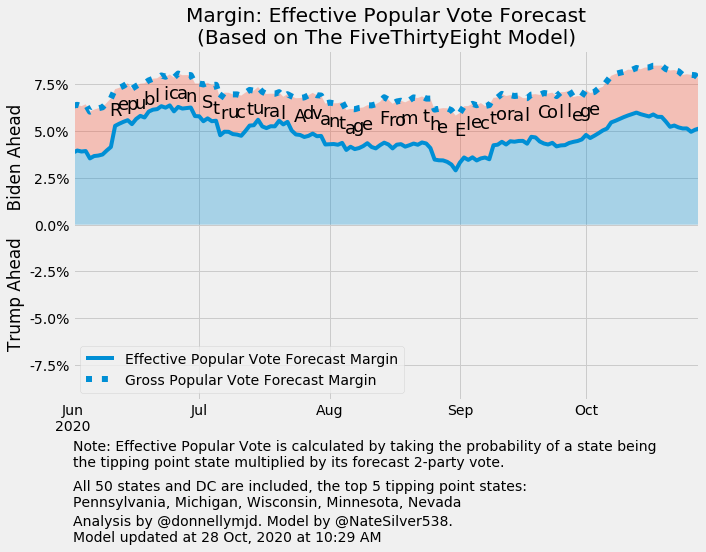

In [13]:
df_chart = pd.DataFrame()

df_chart['trump_weighted'] = tippingpt_margin.div(100).add(1).div(2)
df_chart['biden_weighted'] = 1 - df_chart['trump_weighted']

df_chart = df_chart.diff(axis=1)['biden_weighted']
# display(df_chart)

natl_margin = df_model_national['national_voteshare_chal'].div(two_party_natl).sub(.5).mul(2).sort_index()

ax = df_chart.plot(figsize=[10,6], ylim=[natl_margin.max()*-1.1, natl_margin.max()*1.1],
                   title='Margin: Effective Popular Vote Forecast\n(Based on The FiveThirtyEight Model)',
                  label='Effective Popular Vote Forecast Margin', legend=True)

natl_margin.plot(ax=ax, linestyle=':', color='#008fd5', linewidth=6,
    label='Gross Popular Vote Forecast Margin', legend=True)

plt.fill_between(df_chart.index, df_chart, 0.0, alpha=0.30)
plt.fill_between(df_chart.index, natl_margin, df_chart , alpha=0.30)

ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.1%}'))
ax.set_xlabel('')
ax.set_ylabel('Trump Ahead     Biden Ahead ')
plt.annotate('Note: Effective Popular Vote is calculated by taking the probability of a state being\nthe tipping point state multiplied by its forecast 2-party vote.',
                 (0, 0), (0, -40), xycoords='axes fraction', textcoords='offset points', va='top')
plt.annotate('All 50 states and DC are included, the top 5 tipping point states:\n{}'.format(', '.join(top5contribs)),
                 (0, 0), (0, -80), xycoords='axes fraction', textcoords='offset points', va='top')
plt.annotate('Analysis by @donnellymjd. Model by @NateSilver538.\nModel updated at {}'.format(
        df_model_states.timestamp.max().strftime("%d %b, %Y at %I:%M %p")),
                 (0, 0), (0, -115), xycoords='axes fraction', textcoords='offset points', va='top')


import itertools
(xmin, xmax), (ymin, ymax) = ax.get_xlim(), ax.get_ylim()

# calculate a shape factor, more explanation on usage further
# it is a representation of the distortion of the actual image compared to a 
# cartesian space:
fshape = abs(10*(xmax - xmin)/(ymax - ymin)/6)

# the text you want to plot along your line
thetext = '     Republican Structural Advantage From the Electoral College'

# generate a cycler, so that the string is cycled through
lettercycler = itertools.cycle(tuple(thetext))

# generate dummy river coordinates
xvals = natl_margin.index
yvals = natl_margin

# every XX datapoints, a character is printed
markerevery = 10
angles = np.rad2deg(np.arctan((yvals[1:]-yvals[:-1])/np.ones(yvals.shape[0])*fshape))

# plot the 'river'
# ax.plot(xvals, yvals, 'b', linewidth=3)

# loop over the data points, but only plot a character every XX steps
for letter_idx in np.arange(0, len(thetext)):
    counter = np.arange(0, len(xvals), 2)[letter_idx]
    # plot the character in between two datapoints
    xcoord = (xvals[counter])
    ycoord = yvals.rolling(3, center=True, win_type='gaussian').mean(std=5)[counter] #(yvals[counter-1] + yvals[counter] + yvals[counter+1])/3

    # plot using the text method, set the rotation so it follows the line,
    # aling in the center for a nicer look, optionally, a box can be drawn
    # around the letter
    ax.text(xcoord, ycoord-0.01, thetext[letter_idx],
            fontsize=18, rotation=angles[counter],
            horizontalalignment='center', verticalalignment='center',
            bbox=dict(facecolor='white', edgecolor='white', alpha=0))

plt.savefig('./output/fivethirtyeight/538_effective_margin_{}.png'.format(pd.Timestamp.today().strftime("%Y%m%d")),
            bbox_inches='tight')


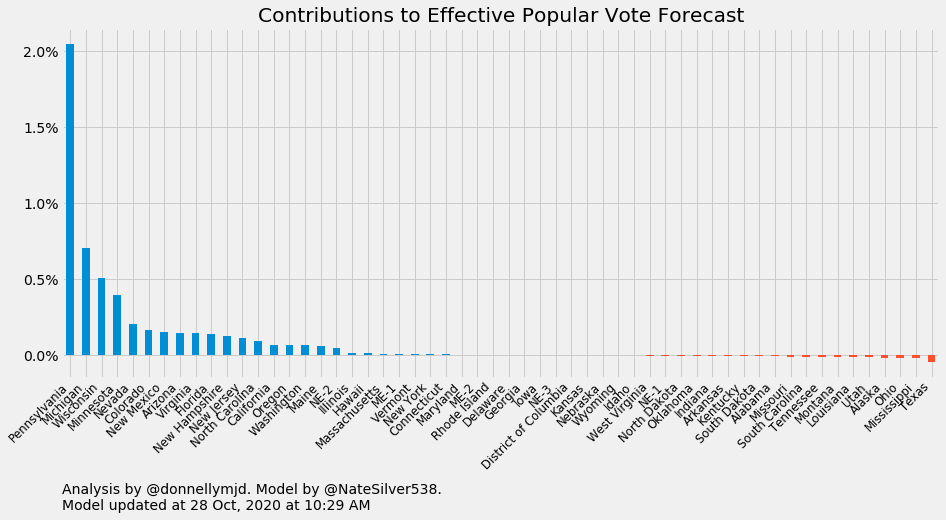

In [14]:
df_chart = tippingpt_margin_bystate.iloc[:,-1].mul(-1/100)
df_chart = df_chart.sort_values(ascending=False)

df_chart_colors = df_chart.copy()
df_chart_colors[df_chart_colors>=0] = '#008fd5'
df_chart_colors[df_chart_colors!= '#008fd5'] = '#fc4f30'

ax = df_chart.plot(kind='bar', legend=False,
                   figsize = [14,6], rot=45, color=df_chart_colors,
                   title='Contributions to Effective Popular Vote Forecast'
                  )

ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.1%}'))

ax.set_xlabel('')
plt.xticks(
    rotation=45,
    horizontalalignment='right',
    fontweight='light',
    fontsize='small',
)
xax_spacing = -20
plt.annotate('Analysis by @donnellymjd. Model by @NateSilver538.\nModel updated at {}'.format(
        df_model_states.timestamp.max().strftime("%d %b, %Y at %I:%M %p")),
                 (0, 0), (0, -105), xycoords='axes fraction', textcoords='offset points', va='top')

plt.savefig('./output/fivethirtyeight/538_prob_swing_contribs_{}.png'.format(pd.Timestamp.today().strftime("%Y%m%d")),
            bbox_inches='tight')


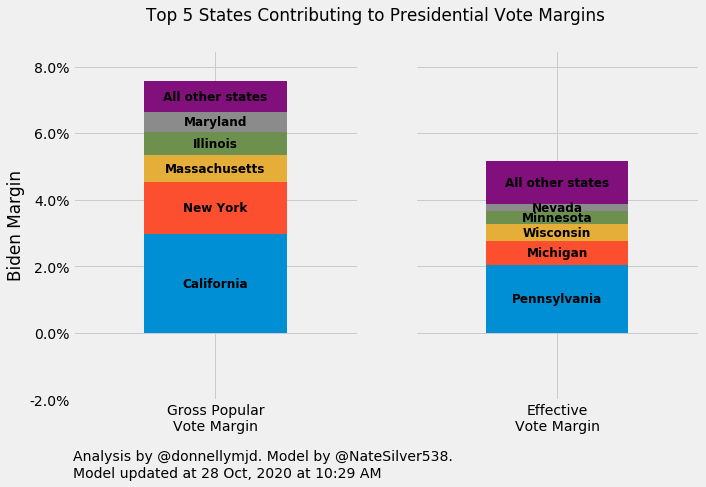

In [71]:
tippingpt_margin_bystate = df_model_states['margin'].mul(df_model_states['tipping']).unstack('modeldate')
top5contribs = tippingpt_margin_bystate.iloc[:,-1].abs().sort_values(ascending=False).iloc[:5].index.to_list()
tippingpt_margin = tippingpt_margin_bystate.sum()

df_chart = pd.DataFrame(tippingpt_margin_bystate.iloc[:,-1].mul(-1/100).sort_values(ascending=False))
df_chart.columns = ['effective_margin_contrib']
df_chart['actual_margin_contrib'] = df_model_states['margin'].mul(df_model_states['state_turnout']).div(
    df_model_states['state_turnout'].unstack('modeldate').sum()).unstack('modeldate').iloc[:,-1].mul(-1/100)

df_chart['state2'] = df_chart.index

top5_effective = df_chart.effective_margin_contrib.abs().sort_values(ascending=False).index[:5].to_list()
top5_actual = df_chart.actual_margin_contrib.abs().sort_values(ascending=False).index[:5].to_list()
othertxt = 'All other states'

df_chart_actual = df_chart.copy()
df_chart_actual['state2'] = df_chart_actual['state2'].apply(lambda x: othertxt if x not in top5_actual else x)
df_chart_actual = df_chart_actual.groupby('state2').sum().loc[top5_actual+[othertxt]]
df_chart_actual = df_chart_actual.rename(columns={'actual_margin_contrib':'Gross Popular Vote Margin'}).T

df_chart_effective = df_chart.copy()
df_chart_effective['state2'] = df_chart_effective['state2'].apply(lambda x: othertxt if x not in top5_effective else x)
df_chart_effective = df_chart_effective.groupby('state2').sum().loc[top5_effective+[othertxt]]
df_chart_effective = df_chart_effective.rename(columns={'effective_margin_contrib':'Effective Vote Margin'}).T

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[10,6])
fig.suptitle('Top 5 States Contributing to Presidential Vote Margins')

df_chart_actual.loc[['Gross Popular Vote Margin']].plot(kind='bar', stacked=True, ax = ax1, 
                                                   ylim=[-.02, natl_margin.max()],
                                                   legend=False)
ax1.set_xticklabels(['Gross Popular\nVote Margin'], rotation=0)
for rect_idx in range(0, len(ax1.patches)):
    rect = ax1.patches[rect_idx]
    # Find where everything is located
    height = rect.get_height()
    width = rect.get_width()
    x = rect.get_x()
    y = rect.get_y()
    
    # The height of the bar is the data value and can be used as the label
    label_text = df_chart_actual.columns[rect_idx] #f'{width:.2f}%'  # f'{width:.2f}' to format decimal values
    
    # ax.text(x, y, text)
    label_x = x + width / 2
    label_y = y + height / 2
    
    # only plot labels greater than given width
    if width > 0:
        ax1.text(label_x, label_y, label_text, ha='center', va='center', fontsize=12, fontweight='bold')
ax1.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.1%}'))
ax1.set_xlabel('')
ax1.set_ylabel('Biden Margin')

df_chart_effective.loc[['Effective Vote Margin']].plot(kind='bar', stacked=True, ax = ax2, sharey=True,
                                                         ylim=ax1.get_ylim(), legend=False)
ax2.set_xticklabels(['Effective\nVote Margin'], rotation=0)
for rect_idx in range(0, len(ax1.patches)):
    rect = ax2.patches[rect_idx]
    # Find where everything is located
    height = rect.get_height()
    width = rect.get_width()
    x = rect.get_x()
    y = rect.get_y()
    
    # The height of the bar is the data value and can be used as the label
    label_text = df_chart_effective.columns[rect_idx] #f'{width:.2f}%'  # f'{width:.2f}' to format decimal values
    
    # ax.text(x, y, text)
    label_x = x + width / 2
    label_y = y + height / 2
    
    # only plot labels greater than given width
    if width > 0:
        ax2.text(label_x, label_y, label_text, ha='center', va='center', fontsize=12, fontweight='bold')
ax2.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.1%}'))
ax2.set_xlabel('')
ax2.set_ylabel('')


ax1.annotate('Analysis by @donnellymjd. Model by @NateSilver538.\nModel updated at {}'.format(
        df_model_states.timestamp.max().strftime("%d %b, %Y at %I:%M %p")),
                 (0, 0), (0, -50), xycoords='axes fraction', textcoords='offset points', va='top')

plt.savefig('./output/fivethirtyeight/538_prob_swing_contribs_bar_{}.png'.format(pd.Timestamp.today().strftime("%Y%m%d")),
            bbox_inches='tight')


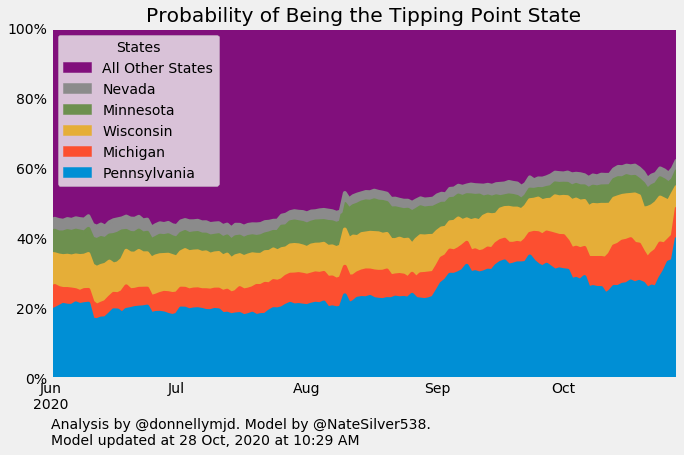

In [73]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset
import matplotlib.dates as mdates

df_chart = pd.DataFrame()
for state in top5_effective:
    df_chart[state] = df_model_states['tipping'].unstack('modeldate').loc[state]
df_chart['All Other States'] = 1-df_chart.sum(axis=1)
ax = df_chart.plot(kind='area', 
                   title='Probability of Being the Tipping Point State',
                   figsize=[10,6])

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1], title='States', loc='upper left')

# inset_days = 30
# axins = inset_axes(ax, width="10%", height="60%", loc=9, borderpad=1,
#                   axes_kwargs={'alpha': .6, 'frame_on': True})

# df_chart.plot(ax=axins, kind='area', legend=False)

# axins.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0%}'))

# axins.set_ylim(0, .7)
# axins.set_xlim(axins.get_xlim()[1]-inset_days, axins.get_xlim()[1])
# axins.set_xlabel('')

# months = mdates.MonthLocator()  # every month
# months_fmt = mdates.DateFormatter('%b')
# axins.xaxis.set_major_locator(months)
# axins.xaxis.set_major_formatter(months_fmt)
# plt.tick_params( labelbottom=False)
# axins.xaxis.set_ticklabels([])
# mark_inset(ax, axins, loc1=2, loc2=4)

# last_dt = df_chart.last_valid_index()
# df_chart_summary = pd.DataFrame(
#     {'Biden':[
#          df_chart.loc[last_dt,'biden_weighted'],
#          df_chart.loc[last_dt,'biden_weighted']
#                          - df_chart.loc[last_dt-pd.Timedelta(days=1),'biden_weighted'],
#          df_chart.loc[last_dt,'biden_weighted']
#                          - df_chart.loc[last_dt-pd.Timedelta(days=7),'biden_weighted'],
#          df_chart.loc[last_dt,'biden_weighted']
#                          - df_chart.loc[last_dt-pd.Timedelta(days=30),'biden_weighted'],
#          df_model_national['national_voteshare_chal'].div(two_party_natl).loc[last_dt]
#              ], 
#      'Trump':[
#          df_chart.loc[last_dt,'trump_weighted'],
#          df_chart.loc[last_dt,'trump_weighted']
#                          - df_chart.loc[last_dt-pd.Timedelta(days=1),'trump_weighted'],
#          df_chart.loc[last_dt,'trump_weighted']
#                          - df_chart.loc[last_dt-pd.Timedelta(days=7),'trump_weighted'],
#          df_chart.loc[last_dt,'trump_weighted']
#                          - df_chart.loc[last_dt-pd.Timedelta(days=30),'trump_weighted'],
#          df_model_national['national_voteshare_inc'].div(two_party_natl).loc[last_dt]
#              ]},
#     index=["Effective Popular Vote Proj. (as of {:%b %d})".format(last_dt),'Change: 1-Day', 'Change: 7-Day', 'Change: 30-Day', 'Nat\'l Popular Vote Proj.']
# )

# df_chart_summary['Diff.'] = df_chart_summary['Biden'] - df_chart_summary['Trump']

# df_chart_summary = df_chart_summary.applymap(lambda x: '{:.1%}'.format(x))

ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0%}'))
ax.set_ylim([0, 1])
ax.set_xlabel('')
plt.annotate('Analysis by @donnellymjd. Model by @NateSilver538.\nModel updated at {}'.format(
        df_model_states.timestamp.max().strftime("%d %b, %Y at %I:%M %p")),
                 (0, 0), (0, -40), xycoords='axes fraction', textcoords='offset points', va='top')

plt.savefig('./output/fivethirtyeight/538_tipping_pt_evol_{}.png'.format(pd.Timestamp.today().strftime("%Y%m%d")),
            bbox_inches='tight')


Text(0, -105, 'Analysis by @donnellymjd. Model by @NateSilver538.\nModel updated at 28 Oct, 2020 at 10:29 AM')

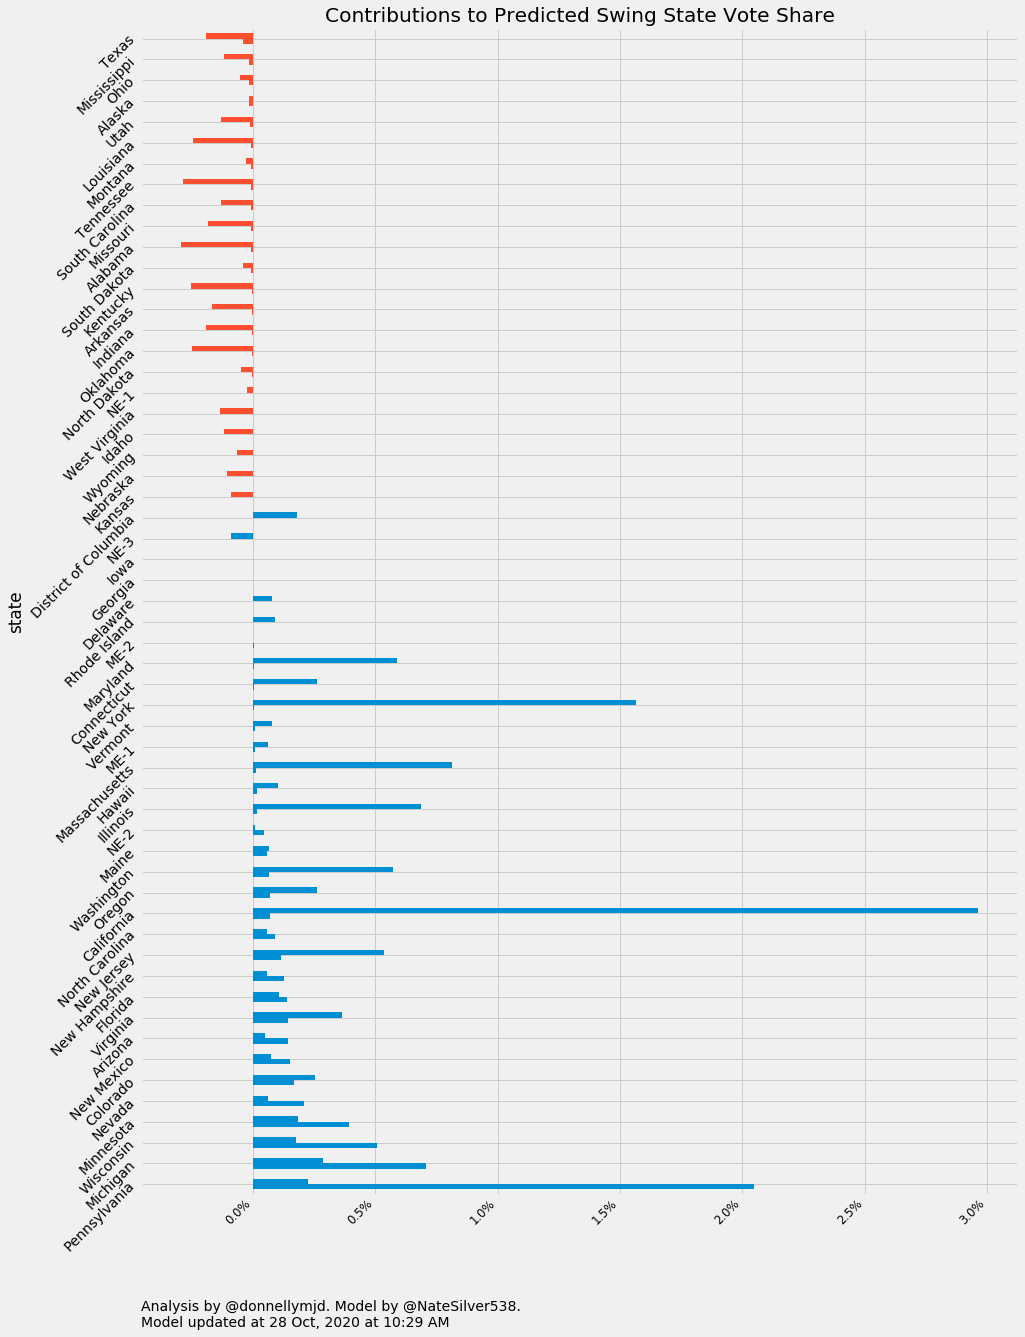

In [18]:
tippingpt_margin_bystate = df_model_states['margin'].mul(df_model_states['tipping']).unstack('modeldate')
top5contribs = tippingpt_margin_bystate.iloc[:,-1].abs().sort_values(ascending=False).iloc[:5].index.to_list()
tippingpt_margin = tippingpt_margin_bystate.sum()

df_chart = pd.DataFrame(tippingpt_margin_bystate.iloc[:,-1].mul(-1/100).sort_values(ascending=False))
df_chart.columns = ['effective_margin_contrib']
df_chart['actual_margin_contrib'] = df_model_states['margin'].mul(df_model_states['state_turnout']).div(
    df_model_states['state_turnout'].unstack('modeldate').sum()).unstack('modeldate').iloc[:,-1].mul(-1/100)
df_chart

df_chart_colors = df_chart.copy()
df_chart_colors[df_chart_colors>=0] = '#008fd5'
df_chart_colors[df_chart_colors!= '#008fd5'] = '#fc4f30'
chart_colors = df_chart_colors['effective_margin_contrib'].to_list()

ax = df_chart.plot(kind='barh', legend=False,
                   figsize = [14,20], rot=45, color=[chart_colors]*2,
                   title='Contributions to Predicted Swing State Vote Share'
                  )

ax.xaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.1%}'))

ax.set_xlabel('')
plt.xticks(
    rotation=45,
    horizontalalignment='right',
    fontweight='light',
    fontsize='small',
)
xax_spacing = -20
plt.annotate('Analysis by @donnellymjd. Model by @NateSilver538.\nModel updated at {}'.format(
        df_model_states.timestamp.max().strftime("%d %b, %Y at %I:%M %p")),
                 (0, 0), (0, -105), xycoords='axes fraction', textcoords='offset points', va='top')

# plt.savefig('./output/fivethirtyeight/538_prob_swing_contribs_{}.png'.format(pd.Timestamp.today().strftime("%Y%m%d")),
#             bbox_inches='tight')


Will try to do a similar analysis using your model when I get time. In the meantime, this approach to understanding the state of the election also gives us a better idea of how much each state's marginal voter is worth relative to the highest value state: PA.

Note the log scale.

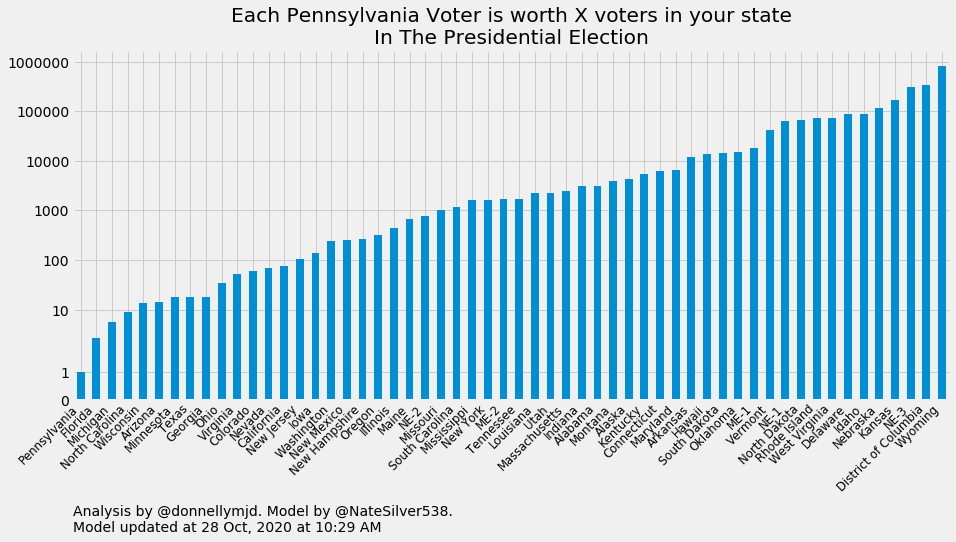

In [19]:
turnout = df_model_states['state_turnout'].unstack('modeldate').iloc[:,-1]
weighted_turnout = df_model_states['tipping'].unstack('modeldate').iloc[:,-1] * turnout
weighted_turnout = weighted_turnout.replace(0, np.nan)
voter_value = weighted_turnout.loc['Pennsylvania']/ weighted_turnout
voter_value = voter_value.fillna(turnout)

ax = voter_value.sort_values().plot(kind='bar', legend=False,
                   figsize = [14,6], rot=45,
                   title='Each Pennsylvania Voter is worth X voters in your state\nIn The Presidential Election'
                  )
ax.set_yscale('symlog')
# ax.yaxis.set_major_formatter(
#     mpl.ticker.FuncFormatter(lambda y,pos: ('{{:.{:1d}f}}'.format(int(np.maximum(-np.log10(y),0)))).format(y)))

ax.yaxis.set_major_formatter(mpl.ticker.ScalarFormatter())
    
ax.set_xlabel('')
plt.xticks(
    rotation=45,
    horizontalalignment='right',
    va='top',
    fontweight='light',
    fontsize='small'
)

plt.annotate('Analysis by @donnellymjd. Model by @NateSilver538.\nModel updated at {}'.format(
        df_model_states.timestamp.max().strftime("%d %b, %Y at %I:%M %p")),
                 (0, 0), (0, -105), xycoords='axes fraction', textcoords='offset points', va='top')

plt.savefig('./output/fivethirtyeight/538_PA_voter_value_{}.png'.format(pd.Timestamp.today().strftime("%Y%m%d")),
            bbox_inches='tight')


In [20]:
df_polls_states.query('state =="Pennsylvania"')

question_id  poll_id  cycle  pollster_id  \
created_at          state                                                    
2020-10-28 10:08:00 Pennsylvania       135175    72100   2020         1193   
                    Pennsylvania       135175    72100   2020         1193   
2020-10-28 10:12:00 Pennsylvania       135227    72100   2020         1193   
                    Pennsylvania       135227    72100   2020         1193   
2020-10-27 08:25:00 Pennsylvania       135049    72039   2020         1447   
...                                       ...      ...    ...          ...   
2019-03-26 10:57:00 Pennsylvania        93786    57754   2020         1483   
2019-03-26 10:58:00 Pennsylvania        93787    57754   2020         1483   
                    Pennsylvania        93787    57754   2020         1483   
                    Pennsylvania        93788    57754   2020         1483   
                    Pennsylvania        93788    57754   2020         1483   

                                      pollster sponsor_ids   sponsors  \
created_at          state                                               
2020-10-28 10:08:00 Pennsylvania  SurveyMonkey         788      Axios   
                    Pennsylvania  SurveyMonkey         788      Axios   
2020-10-28 10:12:00 Pennsylvania  SurveyMonkey         788      Axios   
                    Pennsylvania  SurveyMonkey         788      Axios   
2020-10-27 08:25:00 Pennsylvania        Civiqs         185  Daily Kos   
...                                        ...         ...        ...   
2019-03-26 10:57:00 Pennsylvania       Optimus         NaN        NaN   
2019-03-26 10:58:00 Pennsylvania       Optimus         NaN        NaN   
                    Pennsylvania       Optimus         NaN        NaN   
                    Pennsylvania       Optimus         NaN        NaN   
                    Pennsylvania       Optimus         NaN        NaN   

                                                  display_name  \
created_at          state                                        
2020-10-28 10:08:00 Pennsylvania                  SurveyMonkey   
                    Pennsylvania                  SurveyMonkey   
2020-10-28 10:12:00 Pennsylvania                  SurveyMonkey   
                    Pennsylvania                  SurveyMonkey   
2020-10-27 08:25:00 Pennsylvania                        Civiqs   
...                                                        ...   
2019-03-26 10:57:00 Pennsylvania  Firehouse Strategies/Øptimus   
2019-03-26 10:58:00 Pennsylvania  Firehouse Strategies/Øptimus   
                    Pennsylvania  Firehouse Strategies/Øptimus   
                    Pennsylvania  Firehouse Strategies/Øptimus   
                    Pennsylvania  Firehouse Strategies/Øptimus   

                                  pollster_rating_id pollster_rating_name  \
created_at          state                                                   
2020-10-28 10:08:00 Pennsylvania               324.0         SurveyMonkey   
                    Pennsylvania               324.0         SurveyMonkey   
2020-10-28 10:12:00 Pennsylvania               324.0         SurveyMonkey   
                    Pennsylvania               324.0         SurveyMonkey   
2020-10-27 08:25:00 Pennsylvania               471.0               Civiqs   
...                                              ...                  ...   
2019-03-26 10:57:00 Pennsylvania               245.0              Optimus   
2019-03-26 10:58:00 Pennsylvania               245.0              Optimus   
                    Pennsylvania               245.0              Optimus   
                    Pennsylvania               245.0              Optimus   
                    Pennsylvania               245.0              Optimus   

                                  ... ranked_choice_reallocated  notes  \
created_at          state         ...                                    
2020-10-28 10:08:00 Pennsylvania  ...                     Fa